# SYDE 552 Assignment 1: Neuron Models
### Due Monday, January 29, 11:59pm
### Value: 15% of total marks for the course

The purpose of this assigment is to give you experience working with neuron models of various complexitites. To do so, we'll be using the BRIAN2 neural simulator, a Python library for creating arbitrary spiking neuron models by defining the underlying equations. We'll provide a basic tutorial for BRIAN that should include everything needed to do this assigment, but for additional help and existing neuron implmenetations, see the links below. 

Work in groups of 1-2 people. Your code should be original, but you can borrow ideas and equations from these sources when building your models (please note when you do). Your submission will be a filled-out copy of this notebook (cells for code and written answers provided).

Additional sources
 - Equations: Dayan and Abbott Ch.5-6, Gerstner et al Ch.1-2
 - BRIAN2 documentation: https://brian2.readthedocs.io/en/stable/index.html
 - Working examples: https://brian2.readthedocs.io/en/stable/resources/tutorials/index.html, https://brian2.readthedocs.io/en/stable/user/multicompartmental.html, https://neuronaldynamics-exercises.readthedocs.io/en/latest/

# Install and Import Libraries


Install BRIAN2 (https://brian2.readthedocs.io/en/stable/introduction/install.html). You'll also need jupyter, numpy, scipy, and matplotlib. I reccomend using ```pip``` to install everything: from a terminal, run

```pip install brian2```

```pip install jupyter numpy scipy matplotlib```


open this jupyter notebook with 

```jupyter notebook syde552assigment1.ipynb```

In [1]:
import numpy as np
import scipy
from brian2 import *
import matplotlib.pyplot as plt

# Intro to BRIAN2 (integrate-and-fire models)
BRIAN uses a unit system to give the constants in neuron equations appropriate physical dimensions

In [2]:
v_demo = -65*mV  # voltage
print(v_demo)

-65. mV


BRIAN does unit combinations, but will tell you when units don't match up

In [ ]:
r_demo = 10*ohm  # resistance
i_demo = v_demo/r_demo  # calculate current
print(i_demo)

In [ ]:
v_demo + i_demo  # volts + amps = (invalid) - should produce a DimensionMismatchError

Equations are written as strings, adding a ```: unit``` at the end

In [ ]:
tau = 10*ms
eqn = '''dv/dt = -v/tau : mV'''

Note that ```mV``` describes the unit for the new variable ```v``` that is being defined by the equation, not the quantity on the left-hand-side (which would here be mV/s).

If you want to have the variable be unitless, you can type ```: 1```.

In [ ]:
eqn = '''
dv/dt = (1-v)/tau: 1  # leak towards v_eq=1 
'''

Create a neuron by defining an "ensemble" (population) of neurons

In [ ]:
ens = NeuronGroup(1, eqn, method='exact')  # n=1 neurons in the population, "exact" numerical integration

Set up a probe to record state variables from neurons in ```ens```

In [ ]:
p = StateMonitor(ens, 'v', record=True)

Run the simulation

In [ ]:
run(100*ms)

Plot the result

In [ ]:
fig, ax = plt.subplots()
ax.plot(p.t, p.v[0])  # measuring from the first neuron in "ens" [index=0]
ax.set(xlabel='time (s)', ylabel='voltage')
plt.show()

Now let's add in a spiking mechanism, which includes a "threshold" and a "reset" mechanism.

The ```threshold``` block defines the condition which must be met to register a "spike".

The ```reset``` block defines what happens when a spike occurs.

Before we start, let's explicitly create a scope for this particular model. This avoids accidentally carrying over from variables / constants defined earlier in the notebook.

In [ ]:
start_scope()

tau = 10*ms
v_target = 10*mV
theta = 5*mV
v_reset = -20*mV

eqn = '''dv/dt = (v_target - v)/tau : volt'''

ens = NeuronGroup(1, eqn, threshold='v>theta', reset='v = v_reset', method='euler')

Notice that we started using real units, and changed our numerical integration scheme to a simple numerical solver (Euler's Method)

We also need to define a new type of probe to collect spikes

In [ ]:
p = StateMonitor(ens, 'v', record=True)
p_s = SpikeMonitor(ens)

In [ ]:
run(50*ms)

fig, ax = plt.subplots()
ax.plot(p.t, p.v[0])
ax.scatter(p_s.t, theta*np.ones((len(p_s.t))), color='r')
ax.set(xlabel='time (ms)', ylabel='voltage (V)')
plt.show()

Reset and refractory mechanisms can also be specified as complex expressions, each defined by its own string.

We'll add a unitless state variable ```a``` that is incremented when a spike occurs, and increases the spike threshold and the refractor period

In [ ]:
start_scope()

tau = 10*ms
v_target = 30*mV
theta = 5*mV
v_reset = -20*mV

eqn = '''
dv/dt = (v_target - v)/tau : volt  (unless refractory)
a : 1  # unitless
'''

thr = '''v > theta + a*volt'''  # convert a to volts to allow addition

rst = '''
v = v_reset
a += 0.01
'''

ref = '''a*200*ms'''

ens = NeuronGroup(1, eqn, threshold=thr, reset=rst, refractory=ref, method='euler')

p_v = StateMonitor(ens, 'v', record=True)
p_a = StateMonitor(ens, 'a', record=True)
p_s = SpikeMonitor(ens)

run(100*ms)

fig, ax = plt.subplots()
ax.plot(p_v.t, p_v.v[0])
ax.plot(p_a.t, p_a.a[0])
ax.scatter(p_s.t, np.zeros((p_s.t.shape)), color='r')
ax.set(xlabel='time (ms)', ylabel='voltage (V)')
plt.show()

# Question 1: LIF Neuron

## 1.1 [2 points] Implement the LIF neuron. Simulate the neuron with a 2mA external current. Plot voltage vs time.

#### Equations: 
$\frac{dV}{dt} = -\frac{1}{RC}(V - E_{leak}) + \frac{1}{C}I_{ext}$

if $V>V_{thr}$:
- set $V=V_{reset}$
- begin a refractory period of $\tau_{ref}$ ms
 
#### Constants:
 - $R = 10$ ohm
 - $C = 1$ mfarad
 - $\tau_{ref} = 2$ ms
 - $E_{leak} = -65$ mV
 - $V_{thr} = -50$ mV
 - $V_{reset} = -80$ mV
 - $I_{ext} = 2$ mA
 
#### Notes
 - set state variables using ```ens.v = v_initial```

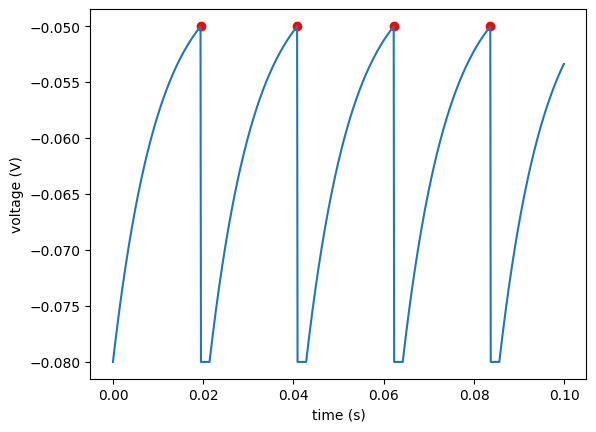

In [27]:
# your solution here
start_scope()
# constant = ...
R = 10*ohm
C = 1*mfarad
T_ref = 2*ms
E_leak = -65*mV
V_thr = -50*mV
V_reset = -80*mV
I_ext = 2*mA
# eqn = ''' dv/dt = ... : volt'''
eqn = '''dv/dt = -1/(R*C)*(v-E_leak) + 1/C*I_ext : volt (unless refractory)'''
# threshold = ''' ... '''
thr = '''v > V_thr'''  # convert a to volts to allow addition




# reset = ''' ... '''
rst = '''
v = V_reset
'''
# refractory = ''' ... '''
ref = '''T_ref'''
# ens = NeuronGroup(...)
ens = NeuronGroup(1, eqn, threshold=thr, reset=rst, refractory=ref, method='exact')
ens.v = V_reset
# probe = ...
p_v = StateMonitor(ens, 'v', record=True)
p_s = SpikeMonitor(ens, variables=['v'])
# run(100*ms)

run(100*ms)

# figure = ...
fig, ax = plt.subplots()
ax.plot(p_v.t, p_v.v[0])

ax.scatter(p_s.t, p_s.v, color='r')
ax.set(xlabel='time (s)', ylabel='voltage (V)')
plt.show()

## 1.2 [2 points] Create response curves for the LIF neuron
 - (a) Inject a constant test current into the neuron, run the simulation, and count the number of spikes. Repeat this for a variety of test currents, then plot average firing rate (spikes/second) versus input current.
 - (b) Choose a new value of R or C, run the experiment from (a) again, and add the new response curve to your plot
 - (c) Choose a new value of tau_ref, run the experiment from (a) again, and overlay the new resopnse curve to your plot

#### Parameters
- Test currents: 1-20mA in increments of 0.5mA
- Simulation duration: $200$ms

In [ ]:
# your solution here

# def LIF_response(I, R, C, tau_ref):
    # ...
    # run(100*ms)
    # return (spike_count)
    
# for i in range(len(I)):
#     spike_counts_a[i] = LIF_response(I[i], R1, C1, tau_ref1)
# for i in range(len(I)):
#     spike_counts_b[i] = LIF_response(I[i], R2, C2, tau_ref1)
# for i in range(len(I)):
#     spike_counts_c[i] = LIF_response(I[i], R1, C1, tau_ref2)

# plot spike_counts_a, spike_counts_b, spike_counts_c

## 1.3 [2 points] Add an adaptation term to the LIF neuron. Calculate the inter-spike-interval and plot it versus spike number to demonstrate adaptation.
 - Inter-spike-interval (ISI) is defined as the length of time between two spikes. To calculate it, compute the difference between the spike times returned from a BRIAN spike monitor
   - tip: use ```np.diff()```
 - Plot the resulting array of values as a scatter plot: $y$ values will be ISI in ms, and $x$ values will range from $1$ to $C$, the spike count value at the end of the simulation.

#### Additional Equations
$\frac{da}{dt} = -\frac{a}{\tau_a}$

$v_{thr} = -50mV + a$

if $v > v_{thr}$:
  - $a = a + \Delta A$
  
#### Additional Constants
- $I_{ext} = 2$mA
- $\tau_a = 100$ ms
- $\Delta A = 1$ mV
- runtime = 500 ms

In [ ]:
# your solution here

## [Bonus] 1.4 [1 point] Read about other extensions to the LIF model, such as quadratic- or exponential-integrate-and fire. Implement that neuron model, then
 - (a) plot the voltage trace
 - (b) plot the response curve
 - (c) plot spike adaptation

In [ ]:
# your solution here (optional)

# Question 2: Wilson Neuron
In his 1999 paper "Simplified dynamics of human and mammalian neocortical neurons", Wilson reduced the Hodgkin-Huxley model down to three coupled differential equations. He showed that this neuron model reproduced action potential dynamics and other electrophysiological measures without any artificial reset mechanisms.

- $\tau_v \frac{dv}{dt} = -(17.81 + 47.58v + 33.80v^2)(v - 0.48) - 26r(v + 0.95) - 13h(v + 0.95) + I_{ext}$
- $\tau_r \frac{dr}{dt} = -r + 1.29v + 0.79 + 3.30(V + 0.38)^2$
- $\tau_h \frac{dh}{dt} = -h + 11(v + 0.754)*(v + 0.69)$

where $v$ is voltage, $r$ is a recovery variable, and $h$ is a conductance variable.

- $\tau_v = 0.97$ms
- $\tau_r = 5.6$ms
- $\tau_H = 99.0$ms
- $dt = 0.05$ms

## 2.1 [2 points] Implement the Wilson Neuron.  Produce an action potential by injecting an external current (I=3 for 0.1ms). Plot voltage vs time. How does the shape of the action potential compare to observed electrophysiology?

#### Tips:
 - Units are weirdly defined in this model: ```v``` varies between $-0.9$ and $0.3$, and time constants are given in seconds. It's easiest to just make the state variables unitless (e.g.```dv/dt = ... : 1```)
 - set the simulation timestep using ```defaultclock.dt = 0.025*ms```
 - set initial conditions to keep the neuron from firing a transient spike at simulation startup:
  - $v_0=-0.75$
  - $r_0=0.2$
 - use ```v**2``` to write powers in an ```eqn=''' ... '''``` block, not ```v^2```
 - run the simulation long enough to observe the full recovery period

In [ ]:
# your solution here

##### Your description of the action potential here

### 2.2 [1 point] Coupled ODEs in complex neuron models are numerically sensitive, and the system can explode under certain conditions. Show that increasing the timestep or injecting a powerful, sustained current produces unrealistic voltage traces.

In [ ]:
# your solution here

## 2.3 [1 point] Show the Wilson neuron exhibits spike adaptation by plotting ISI versus spike number. How does this adaptation compare to the adaptive LIF neuron from Question 1.3?

#### Note
- you will need to think of a good way to define a "spike" for continuous voltages

In [ ]:
# your solution here

# Intro to BRIAN2 (compartmental models)

BRIAN2 also support multicompartment models (https://brian2.readthedocs.io/en/stable/user/multicompartmental.html).  In addition to defining the equations governing the membrane dynamics (i.e. ion channels), building a compartmental neuron requires specifying a morphology. To do this, we'll use BRIAN2's pre-built sections

In [ ]:
soma = Soma(diameter=30*um)  # defines a sphere

Attach new sections to a previously defined section like so

In [ ]:
soma.axon = Cylinder(length=100*um, diameter=1*um, n=10)  # n=10 compartments in this section
soma.dendrite = Cylinder(length=50*um, diameter=2*um, n=5)
soma.dendrite.branch1 = Cylinder(length=10*um, diameter=1*um, n=3)
soma.dendrite.branch2 = Cylinder(length=10*um, diameter=1*um, n=3)

Now we can define a SpatialNeuron according to our biophysical equations. BRIAN will automatically solve the cable equation between all the compartments, so specifying $\frac{dv}{dt}$ and $\frac{d^2v}{dx^2}$ is unnecessary: the user only needs to define the transmembrane and external currents. Notice that physical constants and state variables are now defined relative to space.

In [ ]:
gL = 1e-4*siemens/cm**2  # leak conductance
Cm = 1*uF/cm**2  # membrane capacitance
Ri = 100*ohm*cm  # longitudinal (intracellular) resistivity
EL = -70*mV  # leak reversal potential

eqn = '''
Im = gL * (EL - v) : amp/meter**2  # total ionic (membrance) current
I : amp (point current)  # external current
# dv/dt, d2v/dx2, and I_long are calculated automatically
'''

neuron = SpatialNeuron(morphology=soma, model=eqn, Cm=Cm, Ri=Ri)

Set the membrane voltage of all compartments to -65mV, then apply an external current a few specific compartments. Note the use of ```.main``` to target a specific compartment

In [ ]:
neuron.v = EL + 10*mV  # applies to state variables in soma compartment AND all connected compartments
neuron.main.v = EL + 10*mV  # applies to state variables in soma compartment
neuron.main.I[0] = 1*nA  # applies only to soma
neuron.dendrite.I[3] = 0.5*nA  # applies to a compartment part way down the dendrite
neuron.dendrite.branch1.I[1] = 0.5*nA

To detect spikes, we'll add a threshold condition. To ensure that multiple spikes don't get registered if this condition remains true for a while (e.g. v>v_thr), we'll also specify a refractory condition.

In [ ]:
neuron = SpatialNeuron(morphology=soma, model=eqn,
    threshold='v > 0*mV',
    threshold_location=neuron.main[0],
    refractory='v > 0*mV',
    method="exponential_euler")

# Question 3: Hodgkin Huxley Neurons

A template for the Hodgkin-Huxley model is provided below, including various physical constants and a simple morphology. Note that voltage has been rescaled to $v_{rest} = 0$mV, and the equations for the gating variables have shifted accordingly.

## 3.1 [2 points] Implement the Hodgkin-Huxley model by filling in the provided template. Plot voltage vs time and $m$, $n$, and $h$ versus time for an external input of ```1uA``` applied over ```3ms```. 

In [ ]:
start_scope()

E_leak = 10.613*mV
E_na = 115*mV
E_k = -12*mV
g_leak = 0.3*msiemens/cm**2
g_na = 120*msiemens/cm**2
g_k = 36*msiemens/cm**2
C_m = 1*uF/cm**2
R_l = 35.4*ohm*cm

# Fill in these equations
eqn = '''
Im = [...]  : amp/meter**2
dm/dt = [...] : 1
dn/dt = [...] : 1
dh/dt = [...] : 1

alpha_m = (0.1/mV) * 10*mV/exprel((-v+25*mV)/(10*mV))/ms : Hz  # exprel(x) := (exp(x) - 1)/x
beta_m = 4 * exp(-v/(18*mV))/ms : Hz
alpha_h = 0.07 * exp(-v/(20*mV))/ms : Hz
beta_h = 1/(exp((-v+30*mV) / (10*mV)) + 1)/ms : Hz
alpha_n = (0.01/mV) * 10*mV/exprel((-v+10*mV)/(10*mV))/ms : Hz
beta_n = 0.125*exp(-v/(80*mV))/ms : Hz
I : amp (point current)  # applied external current
'''

cable = Cylinder(length=10*cm, diameter=2*238*um, n=1000, type='axon')

neuron = SpatialNeuron(morphology=cable, model=eqn, method="exponential_euler", Cm=C_m, Ri=R_l)

neuron.v = 0*mV
neuron.h = 0.6
neuron.m = 0.1
neuron.n = 0.3
defaultclock.dt = 0.01*ms

run(10*ms)
neuron.I[0] = 1*uA # current injection at one end of the axon
run(3*ms)
neuron.I = 0*uA
run(10*ms)

# plots here

## 3.2 [0.5 point] Show that the action potential propagates down the cable with minimal attenuation.
- (a) plot voltage vs time at three points on the ```cable```: the left edge, center, and right edge.
- (b) increase the longitudinal resistance and show that the signal propagates slower. 

In [ ]:
# your solution here

## 3.3 [0.5 point] Create a stimulus that produces a rebound spike, and plot the resulting voltage trace

In [ ]:
# your solution here

## 3.4 [2 points] Create a new cell morphology that includes a soma and a dendritic tree with one branch. Show that voltage attenuation increases with the distance from the soma.
- Use ```Cylinder()``` for dendritic sections, with geometric parameters in these ranges:
 - ```length=10-100um```
 - ```diameter=0.1-1um```
 - ```n=5-100```
- Choose several points along the tree as injection sites.
- For each site, apply an identical external current ```I=100*pA``` and measure the resulting voltage change at the soma ($\Delta v = v_{rest} - v_{max}$).
- Plot $\Delta v$ vs distance. How does attenuation vary within a section and between sections (especially at branch points)?

In [ ]:
# your solution here

# soma = Soma()
# soma.d1 = Cylinder(...)
# soma.d1.d2 = Cylinder(...)
# soma.d1.d3 = Cylinder(...)

Your description of attenuation here